<a href="https://colab.research.google.com/github/MahmoodAbdali79/Telecom-Churn/blob/main/Telecom_Churn_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seting Up

In [273]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

In [274]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data & Manipulation

In [275]:
df = pd.read_csv('drive/MyDrive/Data/Telco-Customer-Churn.csv')

In [276]:
def preprocess(df):
  # drop Customer ID
  df.drop(['customerID'], axis=1, inplace=True)

  # turn into numerical and fill NA value
  df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
  df['TotalCharges_missing'] = df['TotalCharges'].isnull().astype(int)

  imputation_value = df['TotalCharges'].mode()[0] # for considering mode
  # imputation_value = df['TotalCharges'].mean() # for considering mean
  # imputation_value = df['TotalCharges'].median() # for considering median
  df['TotalCharges'] = df['TotalCharges'].fillna(imputation_value)

  # drop rows with tenure of 0
  df.drop(labels=df[df['tenure']==0].index, axis=0, inplace=True)

  # map SeniorCitizen
  df['SeniorCitizen'] = df['SeniorCitizen'].map({0:"No", 1:"Yes"})

  for col in df.columns:
    if len(df[col].unique()) < 2:
      df.drop(col, axis=1, inplace=True)
  return df

In [277]:
df = preprocess(df)

# Feature Engineering

 ## Feature Encoding


  - Quantitative data:
    - [ ] Tranformation
    - [ ] Bining
    - [ ] Demention reduction
    - [ ] Standard and scale
  - Categorical data:
    - [ ] One hot encoding
    - [x] Lable endcoding
    - [ ] Hashing

In [278]:
#Create a label encoder object
le = LabelEncoder()
# Label Encoding will be used for columns with 2 or less unique
for col in df.columns:
    if df[col].dtype == 'object':
      le.fit(df[col])
      df[col] = le.transform(df[col])

## Feature Selection

### Filter Method
- Correation
  - Best feature for remove: MonthlyCharges, tenure             
- Vatiance
  - Best feature for remove:  
  PaperlessBilling, gender, Dependents, PhoneService, Partner, SeniorCitizen
- Univariate feature selection:
  - Best feature for remove:  
  MultipleLines, gender, StreamingTV, StreamingMovies, PhoneService, InternetService

#### Correation

In [279]:
corr = df.corr()

threshold = 0.5  # threshold

# Find pairs of features that exceed the threshold
highly_correlated_pairs = []
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if abs(corr.iloc[i, j]) > threshold:
            highly_correlated_pairs.append((corr.index[i], corr.columns[j], corr.iloc[i, j].round(3)))

# Print highly correlated pairs
print("Highly correlated pairs with correlation coefficient > {}: ".format(threshold))
for pair in highly_correlated_pairs:
    print(pair)


corr_omissions = ['tenure', 'MonthlyCharges']

Highly correlated pairs with correlation coefficient > 0.5: 
('tenure', 'Contract', 0.677)
('tenure', 'TotalCharges', 0.826)
('MonthlyCharges', 'TotalCharges', 0.651)


In [280]:
correlation = df.corrwith(df.Churn)
correlation = correlation[correlation!=1].sort_values()
correlation

Contract           -0.396150
tenure             -0.354049
OnlineSecurity     -0.289050
TechSupport        -0.282232
TotalCharges       -0.199484
OnlineBackup       -0.195290
DeviceProtection   -0.177883
Dependents         -0.163128
Partner            -0.149982
InternetService    -0.047097
StreamingMovies    -0.038802
StreamingTV        -0.036303
gender             -0.008545
PhoneService        0.011691
MultipleLines       0.038043
PaymentMethod       0.107852
SeniorCitizen       0.150541
PaperlessBilling    0.191454
MonthlyCharges      0.192858
dtype: float64

#### Vatiance

In [281]:
threshold = 0.5  # Example threshold

# Apply VarianceThreshold
selector = VarianceThreshold(threshold=threshold)
features = df.drop('Churn', axis=1)
selector.fit(features)

# Get selected features
selected_features = features.columns[selector.get_support()]

x = set(selected_features)
y = set(features.columns)
print("Selected features based on variance threshold of {}: ".format(threshold))
print('Potential features to remove: ', y-x)

carianc_omissions = list(y-x)

Selected features based on variance threshold of 0.5: 
Potential features to remove:  {'PaperlessBilling', 'gender', 'Dependents', 'PhoneService', 'Partner', 'SeniorCitizen'}


#### Univariate feature selection

In [282]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split


X = df.drop('Churn', axis=1)
y = df['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform feature selection using ANOVA F-value
k = 13  # Number of features to select
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)
selected_features = X.columns[selector.get_support()]

x = set(selected_features)
y = set(features.columns)
print('Potential features to remove: ', y-x)

univariate_omissions = list(y-x)

Potential features to remove:  {'MultipleLines', 'gender', 'StreamingTV', 'StreamingMovies', 'PhoneService', 'InternetService'}


### conclusion for filtering
- [x] correlation
- [ ] variance
- [ ] univariate

In [283]:
X = df.drop(corr_omissions + ['Churn'], axis=1)
Y = df['Churn']

## Feature Scaling

- [ ] Standardization (Z-score normalization)
- [ ] Min-Max sclaing
- [x] Robust sclaling

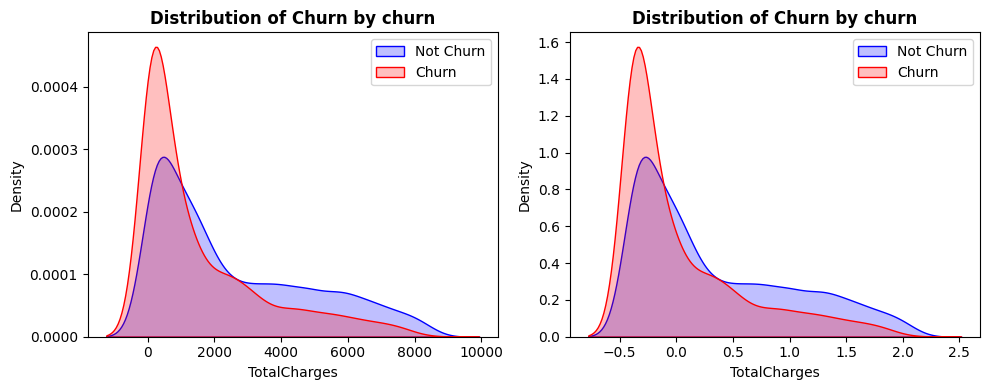

In [284]:
def plot_numerical_feature(cat, ax):
  sns.kdeplot(X[cat][Y==0], color="Blue", fill=True, ax=ax)
  sns.kdeplot(X[cat][Y==1], color="Red", fill= True, ax=ax)
  ax.legend(["Not Churn","Churn"],loc='upper right')
  ax.set_title(f'Distribution of {col} by churn', fontweight="bold")
  fig.tight_layout()


#plot un scaled feature
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_numerical_feature('TotalCharges', axes[0])

#scale feature
robust_scaler = RobustScaler()
X['TotalCharges'] = robust_scaler.fit_transform(X['TotalCharges'].values.reshape(-1, 1))

#plot scaled feature
plot_numerical_feature('TotalCharges', axes[1])
plt.show()

# Model Selection

# Model training and Evaluation

# Deployment